In [216]:
import pandas as pd
import numpy as np
from scipy.stats import sem, mannwhitneyu
from matplotlib import pyplot as plt
import seaborn as sns

In [217]:
df = pd.read_csv("data/data.csv", index_col=0)
df = df.drop(df[df.time == "/"].index)
df = df.drop(df[df.video == "/"].index)
df = df.dropna()
df = df.reset_index()
df.date = pd.to_datetime(df.date, infer_datetime_format=True)
df.time = pd.to_datetime(df.time, infer_datetime_format=True).apply(lambda x: x.time())
df.seconds = pd.to_numeric(df.seconds)
df.day = pd.to_numeric(df.day)
df

,day,date,time,seconds,video
0,1,2021-08-14,11:02:20,6,Over Dubai
1,1,2021-08-14,19:41:28,41,Abstract - Canyon
2,3,2021-08-16,11:08:39,5,Dog POV
3,4,2021-08-17,11:49:42,642,Black hole video
4,4,2021-08-17,19:16:06,500,Two guys on a boat
...,...,...,...,...,...
361,169,2022-02-19,19:54:34,2,Abstract - Canyon
362,169,2022-02-19,19:56:38,10,Beach video
363,169,2022-02-19,20:05:50,6,Temple
364,169,2022-02-19,21:13:47,8,Shower falls


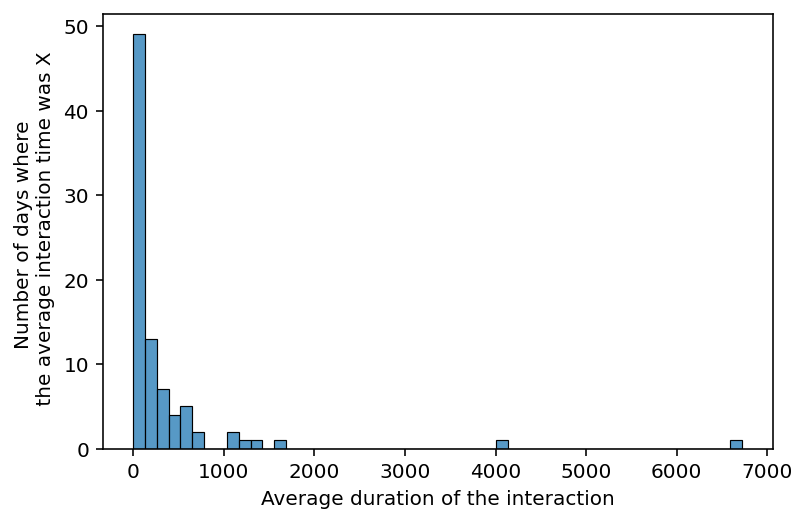

In [218]:
fig, ax = plt.subplots()
sns.histplot(ax=ax, x=df.groupby(df.day)["seconds"].mean())
ax.set_xlabel("Average duration of the interaction")
ax.set_ylabel("Number of days where \n the average interaction time was X");

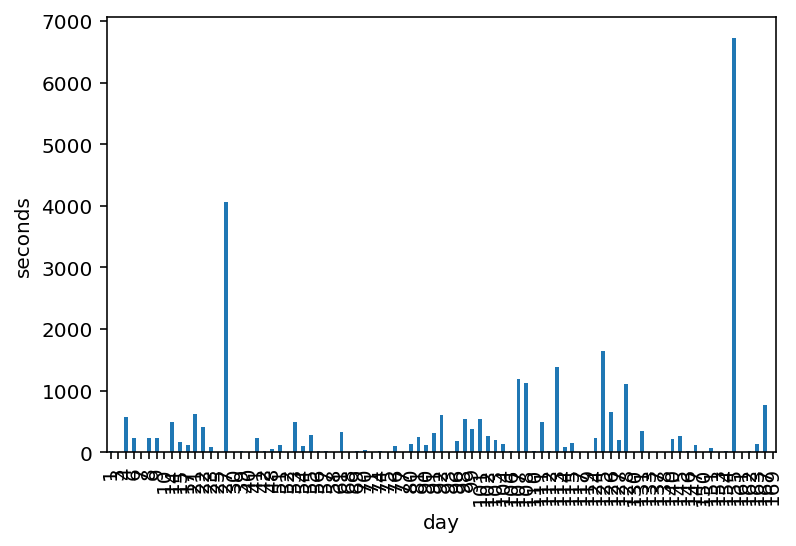

In [222]:
fig, ax = plt.subplots()
avg = df.groupby(df.day)["seconds"].mean()
# qual = qual.sort_values("mean")
avg.plot(kind = "bar", y = "mean", ylabel="seconds", legend = False,
           ax=ax);
# ax.set_xlabel("Day")
# ax.set_ylabel("Number of interaction");

Text(0, 0.5, 'Average number of interaction')

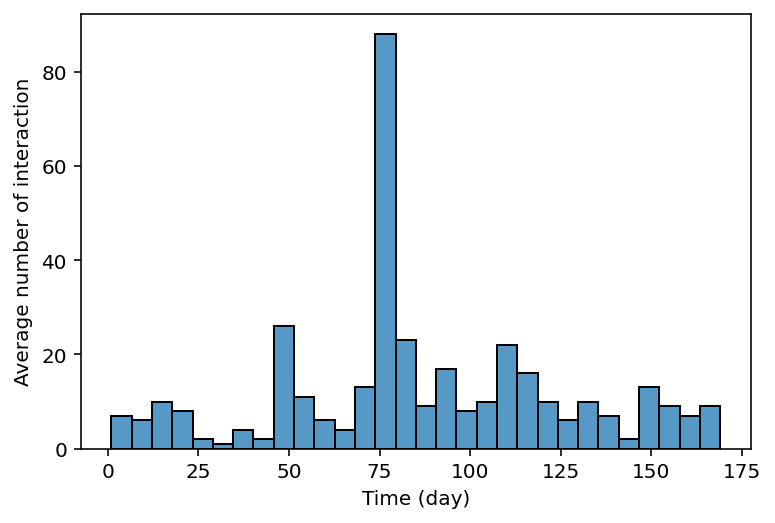

In [225]:
fig, ax = plt.subplots()
sns.histplot(ax=ax, data=df, x="day", kde=False, bins=30)
ax.set_xlabel("Time (day)")
ax.set_ylabel("Average number of interaction")

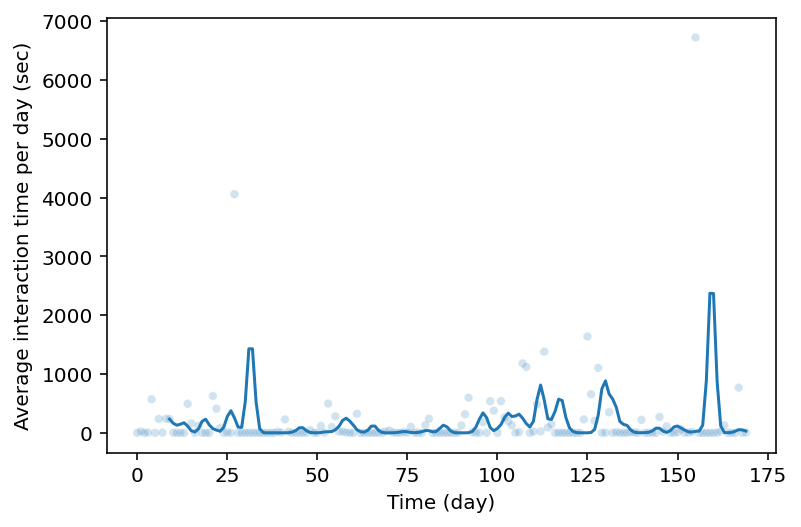

In [226]:
fig, ax = plt.subplots()
x = np.arange(170)
y = np.zeros(170)
series = df.groupby(df.day)["seconds"].mean()
y[series.index] = series.to_numpy()

sns.scatterplot(ax=ax, x=x, y=y, size=1, alpha=0.2, legend=False)
pd.Series(y).rolling(10, win_type='gaussian').mean(std=1.0).plot(ax=ax)

ax.set_xlabel("Time (day)")
ax.set_ylabel("Average interaction time per day (sec)");

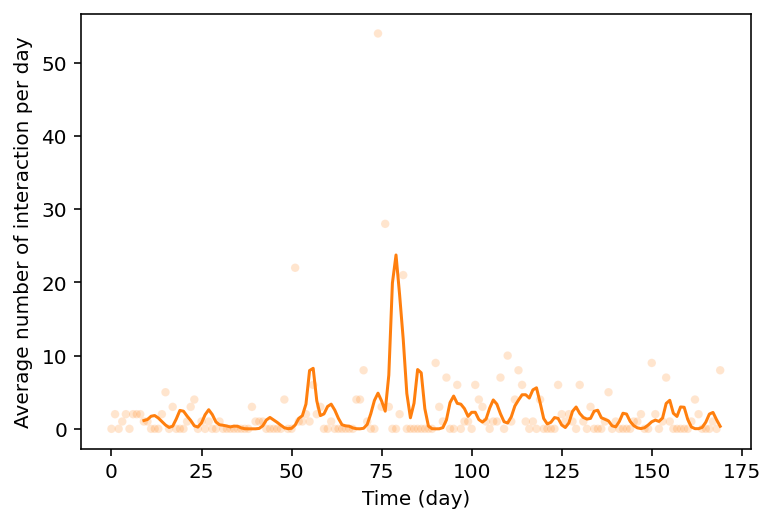

In [227]:
fig, ax = plt.subplots()
x = np.arange(170)
y = np.zeros(170)
series = df.groupby(df.day)["seconds"].count()
y[series.index] = series.to_numpy()

sns.scatterplot(ax=ax, x=x, y=y, size=1, alpha=0.2, legend=False, color="C1")
pd.Series(y).rolling(10, win_type='gaussian').mean(std=1.0).plot(ax=ax, color="C1")

ax.set_xlabel("Time (day)")
ax.set_ylabel("Average number of interaction per day");

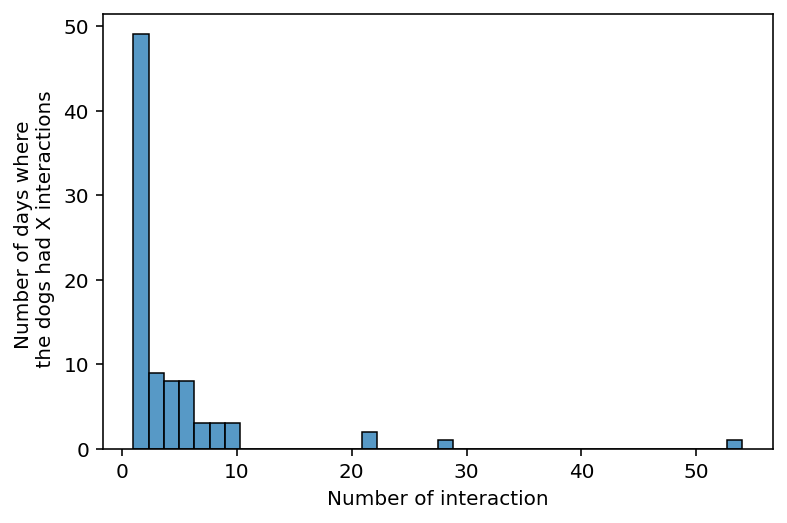

In [228]:
fig, ax = plt.subplots()
x = df.groupby(df.day)["time"].count()
sns.histplot(ax=ax, x=x )
ax.set_xlabel("Number of interaction")
ax.set_ylabel("Number of days where \n the dogs had X interactions");

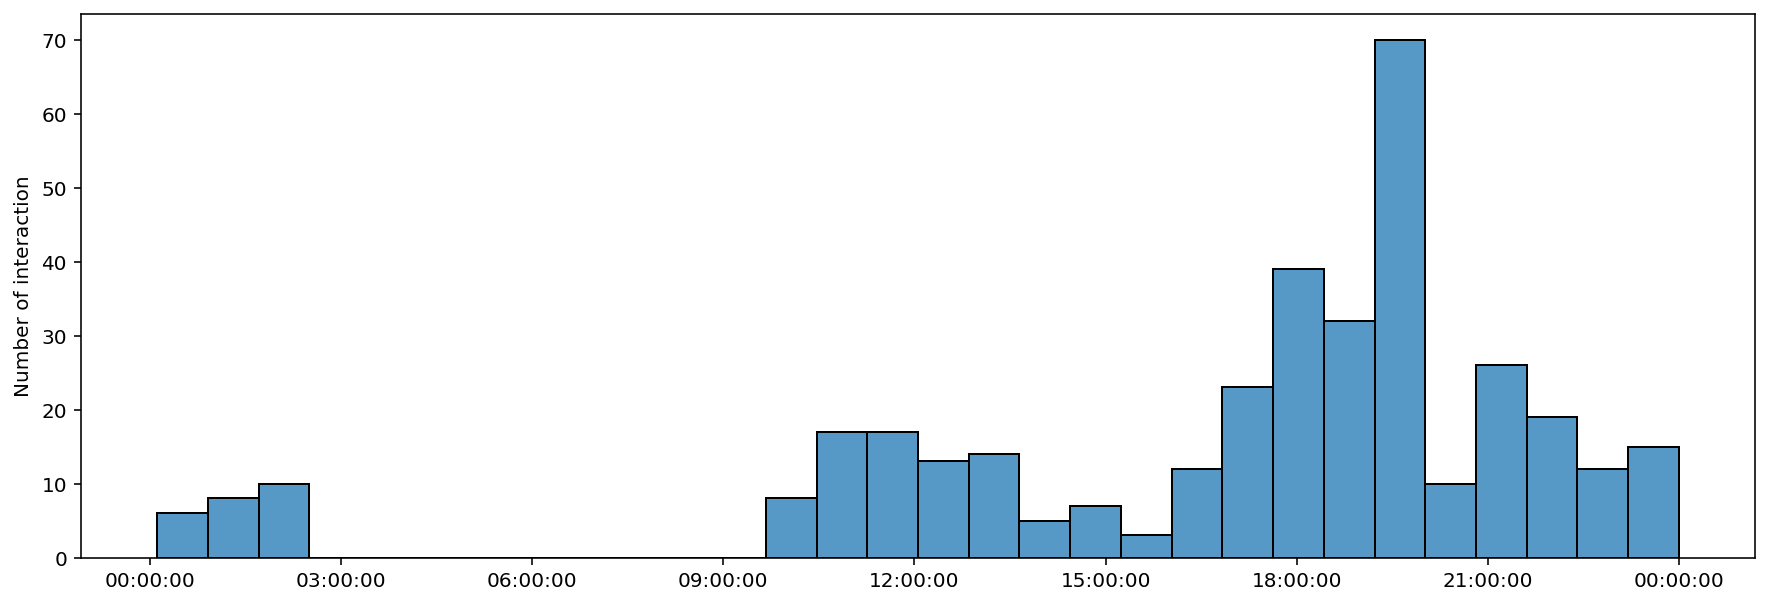

In [229]:
fig, ax = plt.subplots(figsize=(15, 5))
import datetime as dt
from matplotlib import dates
x = []
for index, time in enumerate(df.time):
    x.append(dt.datetime.combine(dt.date(2017, 1, 1), time))
sns.histplot(ax=ax, x=x, kde=False, bins=30)
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Number of interaction");

In [230]:
n_video = len(df.video.unique())
n_video

23

In [231]:
df_labels = pd.read_csv("data/video_labels_05072022.csv")
df_labels

,video,camera_movement,content_movement,color,content_type
0,Abstract - Canyon,fast,fast,changing,abstract
1,Angel falls,slow,slow,changing,nature
2,Bavarian Alps,still,fast,static,nature
3,Barcelona,cut,medium,changing,city
4,Beach video,slow,slow,static,nature
5,Black hole video,slow,slow,static,abstract
6,Blue whale,still,fast,static,animal
7,Dog POV,fast,fast,changing,animal
8,Dog shelter,cut,medium,changing,animal
9,Dog sled,slow,fast,static,animal


In [232]:
video_list = df.video.unique()
video_labels = np.asarray(df_labels.video)

In [233]:
for v in video_list:
    if v not in video_labels:
        print(v)

Text(0, 0.5, 'Average duration of the interaction (sec)')

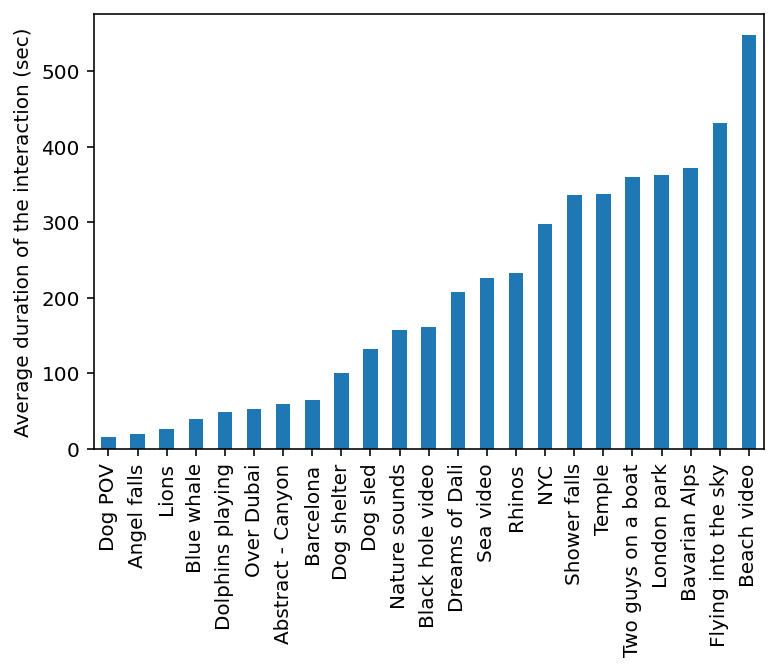

In [234]:
ax = df.groupby('video')['seconds'].mean().sort_values().plot.bar()
ax.set_xlabel("")
ax.set_ylabel("Average duration of the interaction (sec)")

<AxesSubplot:xlabel='video', ylabel='seconds'>

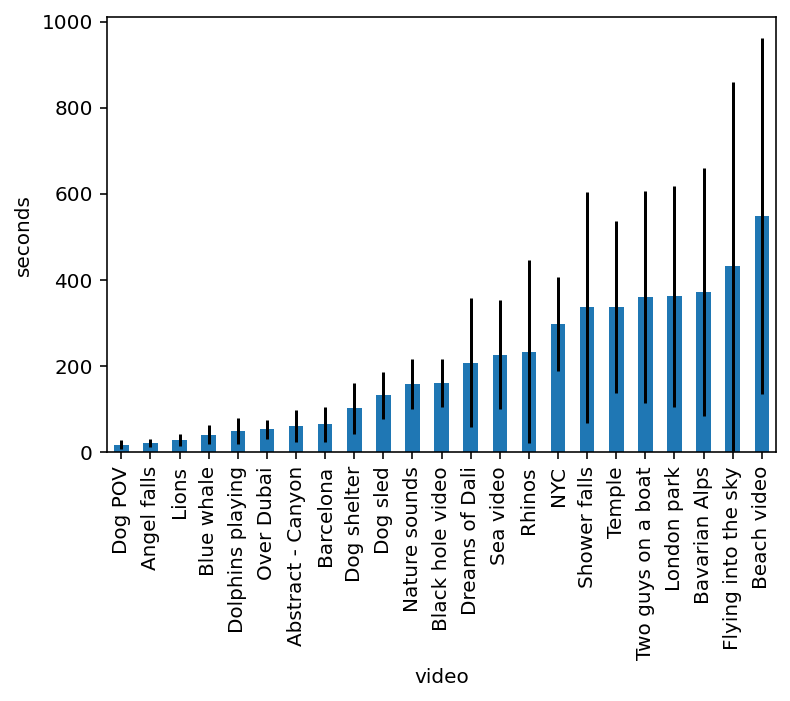

In [286]:
fig, ax = plt.subplots()

avg = df.groupby("video")["seconds"].agg([np.mean, sem])
avg = avg.sort_values("mean")
avg.plot(kind = "bar", y = "mean", ylabel="seconds", legend = False,
          yerr = "sem", ax=ax)

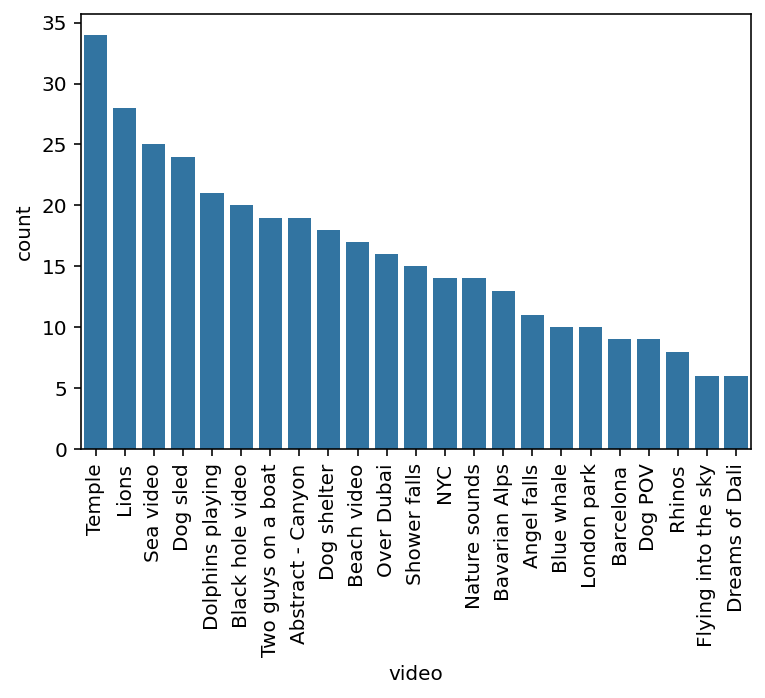

In [282]:
fig, ax = plt.subplots()
# sns.histplot(ax=ax, data=df, x="video")
sns.countplot(x = 'video',
              data = df,
              order = df['video'].value_counts().index, color="C0")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [235]:
label_categories = df_labels.columns.to_list()[1:]
label_categories

['camera_movement', 'content_movement', 'color', 'content_type']

In [236]:
df_labels[df_labels["video"]== "Over Dubai"]["camera_movement"].values[0]

'fast'

In [237]:
for index, row in df.iterrows():
    for cat in label_categories:
        label = df_labels[df_labels["video"] == row.video][cat].values[0]
        df.loc[index, cat] = label

In [238]:
df

,day,date,time,seconds,video,camera_movement,content_movement,color,content_type
0,1,2021-08-14,11:02:20,6,Over Dubai,fast,slow,static,sky
1,1,2021-08-14,19:41:28,41,Abstract - Canyon,fast,fast,changing,abstract
2,3,2021-08-16,11:08:39,5,Dog POV,fast,fast,changing,animal
3,4,2021-08-17,11:49:42,642,Black hole video,slow,slow,static,abstract
4,4,2021-08-17,19:16:06,500,Two guys on a boat,medium,medium,changing,water
...,...,...,...,...,...,...,...,...,...
361,169,2022-02-19,19:54:34,2,Abstract - Canyon,fast,fast,changing,abstract
362,169,2022-02-19,19:56:38,10,Beach video,slow,slow,static,nature
363,169,2022-02-19,20:05:50,6,Temple,slow,medium,changing,nature
364,169,2022-02-19,21:13:47,8,Shower falls,still,fast,static,nature


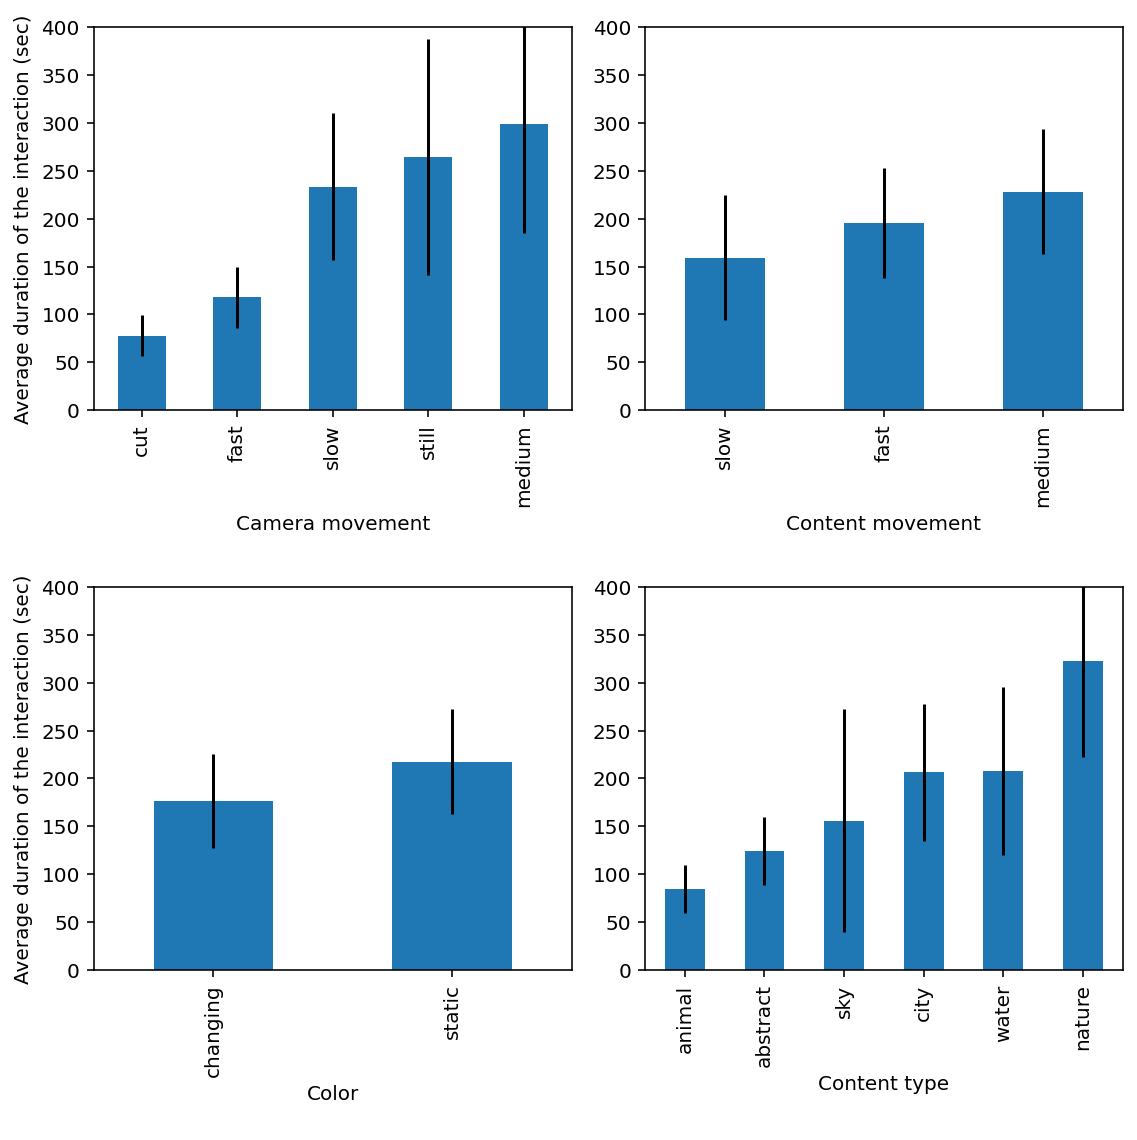

In [239]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axes = axes.flatten()

for i, cat in enumerate(label_categories):
    ax = axes[i] 
    qual = df.groupby(cat)["seconds"].agg([np.mean, sem])
    qual = qual.sort_values("mean")
    qual.plot(kind = "bar", y = "mean", ylabel="seconds", legend = False,
              yerr = "sem", ax=ax)
    ax.set_xlabel(cat.replace("_", " ").capitalize() + "\n")
    if i % 2 == 0:
        ax.set_ylabel("Average duration of the interaction (sec)")
    else:
        ax.set_ylabel("")
    ax.set_ylim(0, 400)
plt.tight_layout()

In [246]:
cat = "color"
modalities = "changing", "static"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
mannwhitneyu(x1, x2)

MannwhitneyuResult(statistic=16003.5, pvalue=0.46458158853709786)

In [247]:
cat = "content_movement"
modalities = "medium", "slow"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
mannwhitneyu(x1, x2)

MannwhitneyuResult(statistic=8660.5, pvalue=0.3095693317456173)

In [249]:
cat = "camera_movement"
modalities = "cut", "medium"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
mannwhitneyu(x1, x2)

MannwhitneyuResult(statistic=1735.0, pvalue=0.5149635992948658)

In [248]:
cat = "content_type"
modalities = "animal", "nature"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
mannwhitneyu(x1, x2)

MannwhitneyuResult(statistic=4872.5, pvalue=0.13706285412376695)

In [267]:
cat = "video"
modalities = "Beach video", "Dog POV"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
mannwhitneyu(x1, x2)

MannwhitneyuResult(statistic=100.0, pvalue=0.21377769730715945)

In [271]:
cat = "video"
modalities = "Beach video", "Angel falls"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
print("n", len(x1), len(x2))
mannwhitneyu(x1, x2)

n 17 11


MannwhitneyuResult(statistic=113.5, pvalue=0.3574082938133444)

In [284]:
cat = "video"
modalities = "Lions", "Temple"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
print("n", len(x1), len(x2))
mannwhitneyu(x1, x2)

n 28 34


MannwhitneyuResult(statistic=384.0, pvalue=0.1941079600126301)

In [14]:
df.seconds.mean()

197.2377049180328

In [15]:
df.seconds.min()

1

In [16]:
df.seconds.max()

7118

Text(0, 0.5, 'Number of interaction')

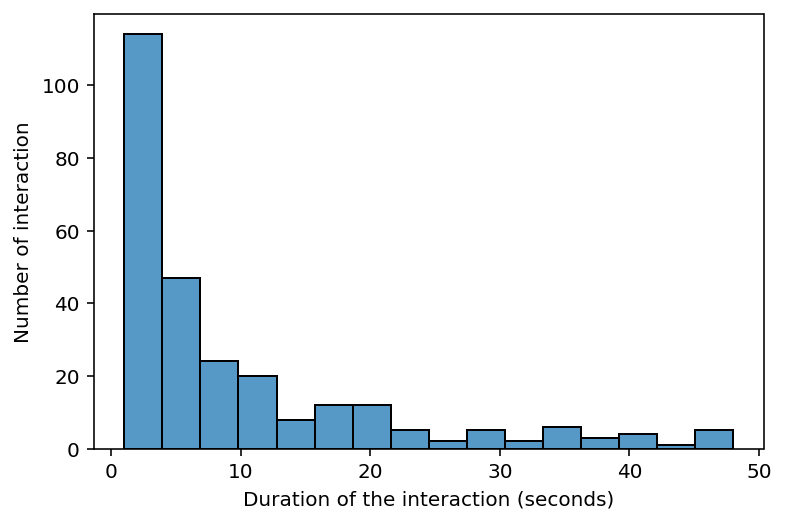

In [85]:
fig, ax = plt.subplots()
sns.histplot(ax=ax, x=df.seconds[df.seconds < 50])
ax.set_xlabel("Duration of the interaction (seconds)")
ax.set_ylabel("Number of interaction")

In [253]:
df_traces = pd.read_csv("traces/traces.csv", index_col=0)
df_traces

,cat,err,learning
0,camera_movement,6.378905,before
1,camera_movement,5.231117,after
2,camera_movement,15.782639,before
3,camera_movement,11.592491,after
4,camera_movement,13.430036,before
...,...,...,...
155,content_type,8.141918,after
156,content_type,7.488688,before
157,content_type,5.389960,after
158,content_type,20.293980,before


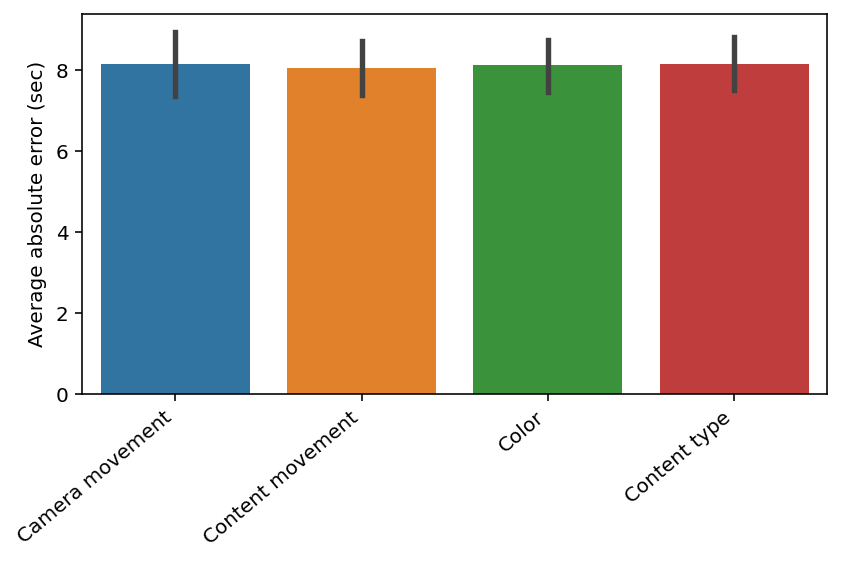

In [254]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, x="cat", y="err", data=df_traces[df_traces.learning == "after"])
labels = [v.get_text() for v in ax.get_xticklabels()]  # get the position and text for each subplot
labels = [v.replace("_", " ").capitalize() for v in labels]

ax.set_ylabel("Average absolute error (sec)")
ax.set_xlabel("")

ax.set_xticklabels(labels, rotation=40, ha="right")

plt.tight_layout()

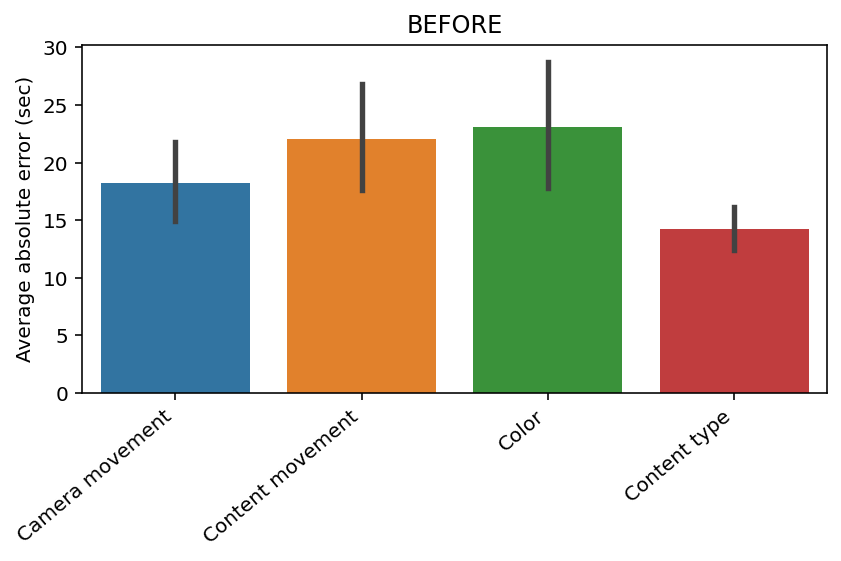

In [255]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, x="cat", y="err", data=df_traces[df_traces.learning == "before"])
labels = [v.get_text() for v in ax.get_xticklabels()]  # get the position and text for each subplot
labels = [v.replace("_", " ").capitalize() for v in labels]

ax.set_ylabel("Average absolute error (sec)")

ax.set_xticklabels(labels, rotation=40, ha="right")

ax.set_title("BEFORE")
ax.set_xlabel("")

plt.tight_layout()

In [250]:
import statsmodels.api as sm

In [266]:
model_lin = sm.OLS.from_formula("seconds ~ camera_movement + content_movement + content_type + color", 
                                data=df)
result_lin = model_lin.fit()
result_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                seconds   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7928
Date:                Fri, 12 Aug 2022   Prob (F-statistic):              0.658
Time:                        17:17:25   Log-Likelihood:                -2913.4
No. Observations:                 366   AIC:                             5853.
Df Residuals:                     353   BIC:                             5904.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     68.5832    227.876      0.301      0.764    -379.583     516.749
camera_movement[T.fast]       21.2586    188.277      0.113      0.910    -349.026     391.543
camera_movement[T.medium]    286.2563    215.619      1.328      0.185    -137.804     710.316
camera_movement[T.slow]      132.9771    161.083      0.826      0.410    -183.826     449.780
camera_movement[T.still]     137.0173    239.704      0.572      0.568    -334.410     608.445
content_movement[T.medium]    -7.8895    132.241     -0.060      0.952    -267.968     252.189
content_movement[T.slow]     -15.7875    141.075     -0.112      0.911    -293.240     261.665
content_type[T.animal]       -33.6788    159.104     -0.212      0.832    -346.590     279.232
content_type[T.city]         127.8249    203.665      0.628      0.531    -272.724     528.374
content_type[T.nature]       136.1897    152.991      0.890      0.374    -164.698     437.078
content_type[T.sky]           54.3014    187.775      0.289      0.773    -314.996     423.599
content_type[T.water]        -82.4659    198.506     -0.415      0.678    -472.869     307.937
color[T.static]               -9.9912    108.560     -0.092      0.927    -223.497     203.515
==============================================================================
Omnibus:                      489.334   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43902.049
Skew:                           6.608   Prob(JB):                         0.00
Kurtosis:                      55.002   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""